In [63]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal, ogr, gdal_array
import dask
import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry
import os
#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices, DEADataHandling
from load_data import load_data
from transform_tuple import transform_tuple
from query_from_shp import query_from_shp
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats
from imageSeg import imageSeg
import fiona
import rasterio.features

import warnings
warnings.filterwarnings('ignore')

In [64]:
# where is your data and results folder?
results = "results/"
# data = 'data/'

sensors = ['ls5','ls7','ls8']

#are we using a polygon to mask the AOI?
shp_fpath = 'data/spatial/murrumbidgee_boundingbox.shp'

#Input your area of interest's name, coords, and 
#the year you're interested in?
AOI = 'Murrum_randomForest'
year = 'Winter2013'

time_period = ('2013-05-01', '2013-09-30')

#What thresholds should I use?
threshold = 0.8
wofs_theshold = 0.15
#-----------------------------------------

In [65]:
#Creating a folder to keep things neat
directory = results + AOI + "_" + year
if not os.path.exists(directory):
    os.mkdir(directory)

results = results + AOI + "_" + year + "/"

In [66]:
#set up query
query = query_from_shp(shp_fpath, time_period[0], time_period[1], dask_chunks = 500)
#landsat
# dc = datacube.Datacube(app='dc_name')
# landsat = DEADataHandling.load_clearlandsat(dc,query=query, sensors=sensors, product='nbart',
#                        masked_prop=0.75)

landsat = load_data(dc_name = 'irrigated_areas', sensors=sensors, export_name = 'fh',query=query)
#wofs
# dc = datacube.Datacube(app='wofs')
# del query['time'] 
# wofs_alltime = dc.load(product = 'wofs_summary', **query)

#masking the returned array to the polygon area
with fiona.open(shp_fpath) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

mask = rasterio.features.geometry_mask([geom.to_crs(landsat.geobox.crs) for geoms in [geom]],
                                           out_shape=landsat.geobox.shape,
                                           transform=landsat.geobox.affine,
                                           all_touched=False,
                                           invert=True)
# Mask the xarrays
landsat = landsat.where(mask)
#wofs_alltime = wofs_alltime.where(mask)
#datacube.storage.storage.write_dataset_to_netcdf(landsat, results + AOI "_" + year + '.nc')

ls5_loading...
ls5_loaded
ls7_loading...
ls7_loaded
ls8_loading...
ls8_loaded


In [67]:
#band indices calculation
def ndvi_ufunc(ds):
    def ndvi_func(nir, red):
        return ((nir - red)/(nir + red))
    
    return xr.apply_ufunc(
        ndvi_func, ds.nir, ds.red,
        dask='parallelized',
        output_dtypes=[float])

def brightness_ufunc(ds):
    def brightness_func(g,r,nir,swir):
        return (g**2 + r**2 + nir**2 + swir**2)**(1/2.0)
    
    return xr.apply_ufunc(
        brightness_func, ds.green,ds.red, ds.nir, ds.swir1,
        dask='parallelized',
        output_dtypes=[float])

NDVI_landsat = ndvi_ufunc(landsat)
brightness_landsat = brightness_ufunc(landsat)
NDMI_landsat = BandIndices.calculate_indices(landsat, index='NDMI-nir')

#calculate NDVI & NDMI stats
print('calculating NDVI & NDMI stats')
NDVI_max = NDVI_landsat.max('time').rename('NDVI_max')
NDVI_mean = NDVI_landsat.mean('time').rename('NDVI_mean')
NDVI_std = NDVI_landsat.std('time').rename('NDVI_std')
NDVI_min = NDVI_landsat.min('time').rename('NDVI_min')
NDVI_range = NDVI_max - NDVI_min
NDVI_range = NDVI_range.rename('NDVI_range')

NDMI_max = NDMI_landsat.max('time').rename('NDMI_max')
NDMI_mean = NDMI_landsat.mean('time').rename('NDMI_mean')
NDMI_std = NDMI_landsat.std('time').rename('NDMI_std')
NDMI_min = NDMI_landsat.min('time').rename('NDMI_min')

#brightness stats
print('calculating brightness stats')
brightness_max = brightness_landsat.max('time').rename('brightness_max')
brightness_mean = brightness_landsat.mean('time').rename('brightness_mean')
brightness_std = brightness_landsat.std('time').rename('brightness_std')
brightness_min = brightness_landsat.min('time').rename('brightness_min')

print('calculating rate and argmax,min')
NDVI_landsat_resample = NDVI_landsat.resample(time='M').mean('time')
def nanarg(xarr, dim, stat):
    """
    Deals with all-NaN slices by first identifying the offending cells
    to create a mask, then filling NaNs with an integer to calculate
    nanargmax(min), then masking out all-NaN cells using the mask.
    The fill number is set such that it will never be returned as the min
    or max of the argmax(min).
    """
    mask = xarr.min(dim=dim, skipna=True).isnull()
    if stat=='max':
        fill = np.nanmin(xarr.values) -1
        y = xarr.fillna(fill)
        y = y.argmax(dim=dim, skipna=True).astype(float)
        y = y.where(~mask)
        return y
    if stat == 'min':
        fill = np.nanmax(xarr.values) + 1
        y = xarr.fillna(fill)
        y = y.argmin(dim=dim, skipna=True).astype(float)
        y = y.where(~mask)
        return y

timeofmax = nanarg(NDVI_landsat_resample,dim ='time', stat='max')
timeofmin = nanarg(NDVI_landsat_resample,dim ='time', stat='min')

rate = (NDVI_max-NDVI_min)/(timeofmax - timeofmin)
rate = rate.where(~np.isinf(rate), other=3) #remove unreasonable values

The formula we are using is (nir - swir1)/(nir + swir1)
calculating NDVI & NDMI stats
calculating brightness stats
calculating rate and argmax,min


In [68]:
xray_list = [NDVI_max, NDVI_mean, NDVI_std, NDVI_min, NDVI_range,
             NDMI_max, NDMI_mean, NDMI_std, NDMI_min,timeofmax, timeofmin, rate,
             brightness_max, brightness_mean, brightness_std, brightness_std]
names = ['NDVI_max', 'NDVI_mean', 'NDVI_std', 'NDVI_min', 'NDVI_range',
         'NDMI_max', 'NDMI_mean', 'NDMI_std', 'NDMI_min','timeofmax', 'timeofmin','rate',
            'brightness_max', 'brightness_mean', 'brightness_std', 'brightness_std']

In [69]:
#convert to numpy arrays (SLOW BECAUSE DASK ARRAYS ARE COMPUTED)
x,y = NDVI_max.shape
z = len(xray_list)
img = np.zeros((x,y,z))
count=0
for b,c in zip(xray_list, range(img.shape[2])):
    count += 1
    progress = round((count/z) * 100, 3)
    print("\r", "adding slice: " + str(count) + ", " + str(progress) + "%" + " complete. ", end = '')
    img[:, :, c] = b.values 
    
img_noNaNs = np.nan_to_num(img) #remove nans as they f/w classifier
np.save(results + 'img_noNaNs_winter2013.npy', img_noNaNs) #save it as binary

 adding slice: 16, 100.0% complete. 

In [70]:
# If we need to load back in the trained RF model:
from joblib import load
rf = load(results + 'murrumbidgee_rfModel.joblib')

# img_noNaNs = np.where(img_noNaNs >1.0e+307, 3, img_noNaNs) #run this if rate is being a bastard

# Take our full image, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img_noNaNs.shape[0] * img_noNaNs.shape[1], img_noNaNs.shape[2])

img_as_array = img_noNaNs[:, :, :z].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img_noNaNs.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
print('generating prediction')
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img_noNaNs[:, :, 0].shape)

Reshaped from (1493, 2379, 16) to (3551847, 16)
generating prediction


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   54.5s finished


Text(0.5, 1.0, 'Irrigation Pixels Only')

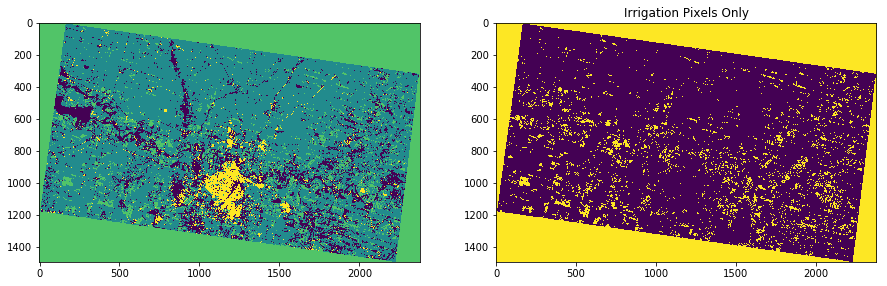

In [71]:
#generate a plot of the predictions
import matplotlib.patches as mpatches
values = np.unique(class_prediction.ravel())

plt.figure(figsize=(15,15))
plt.subplot(121)
im = plt.imshow(class_prediction, interpolation='none')
# colors = [im.cmap(im.norm(value)) for value in values]
# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.subplot(122)
irr = np.where(class_prediction==430, 1, 0)
plt.imshow(irr)
plt.title('Irrigation Pixels Only')

In [72]:
#export out the results
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "classpredict_handtrain_winter2013.tif",
              class_prediction, geo_transform = transform, 
              projection = projection, nodata_val=0)

In [ ]:
class_predict = xr.open_rasterio(results + AOI + "_" + year + "classpredict_handtrain_winter2013.tif")
class_predict = class_predict.squeeze()

gdf = gpd.read_file(results + AOI + '_' + year + '_SEGpolygons.shp')
#calculate majority values inside segments
gdf['majority'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=results + AOI + "_" + year + "classpredict_handtrain_winter2013.tif", stats='majority'))['majority']
#calculate area of polygons
gdf['area'] = gdf['geometry'].area
#filter by area and majority values
smallArea = gdf['area'] <= 5500000
irrigated = gdf['majority'] == 430.0 #filtering for irrigated areas only
gdf = gdf[smallArea&irrigated]
#export shapefile
gdf.to_file(results + AOI + "_" + year + "_Irrigated_winter2013.shp")

#get the transform and projection of our gtiff
transform, projection = transform_tuple(class_predict, (class_predict.x, class_predict.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = class_predict.shape
# rasterize vector
gdf_raster = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_Irrigated_winter2013.shp",
                                           height, width, transform, projection, raster_path=results + AOI + "_" + year + "_Irrigated_winter2013.tif")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(gdf_raster, interpolation='none')